In [210]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from scipy import stats
from sklearn import metrics
%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 12

plt.style.use('tableau-colorblind10')

In [75]:
GPU_TDP = 250 # Watt
CPU_TDP = 85 # Watt
time = 1.6679636111111111 # hours
GPU_utilisation =  98.41828958509737 #percentage
CPU_utilisation = 1 #assumed

In [76]:
dictionary = {'method':[],'energy':[]}

In [77]:
#mlco2 energy used = 0.4169909027777778 kWh
mlco2= (time * GPU_TDP) / 1000
dictionary['method'].append('time * GPU TDP')
dictionary['energy'].append(mlco2)

In [78]:
ai_and_compute = (time * GPU_TDP * 1/3) / 1000
dictionary['method'].append('time * GPU TDP * 1/3 util')
dictionary['energy'].append(ai_and_compute)

In [79]:
actual_util = (time * ( GPU_TDP * GPU_utilisation/100 +  CPU_TDP * CPU_utilisation)) / 1000
dictionary['method'].append('time * (GPU + CPU) * real_util')
dictionary['energy'].append(actual_util)

In [80]:
# empirical values
# nvidia-smi GPU energy consumption = 0.43921391388888886 kWh
# GPU + CPU energy consumption = 0.5627291196798899 kWh
# power monitor reading = 0.6127022608333333 kWh
power_monitor_reading = 0.6127022608333333
dictionary['method'].append('empirical')
dictionary['energy'].append(power_monitor_reading)

In [81]:
df= pd.DataFrame(dictionary)

In [82]:
df.head()

,method,energy
0,time * GPU TDP,0.416991
1,time * GPU TDP * 1/3 util,0.138997
2,time * (GPU + CPU) * real_util,0.552172
3,empirical,0.612702


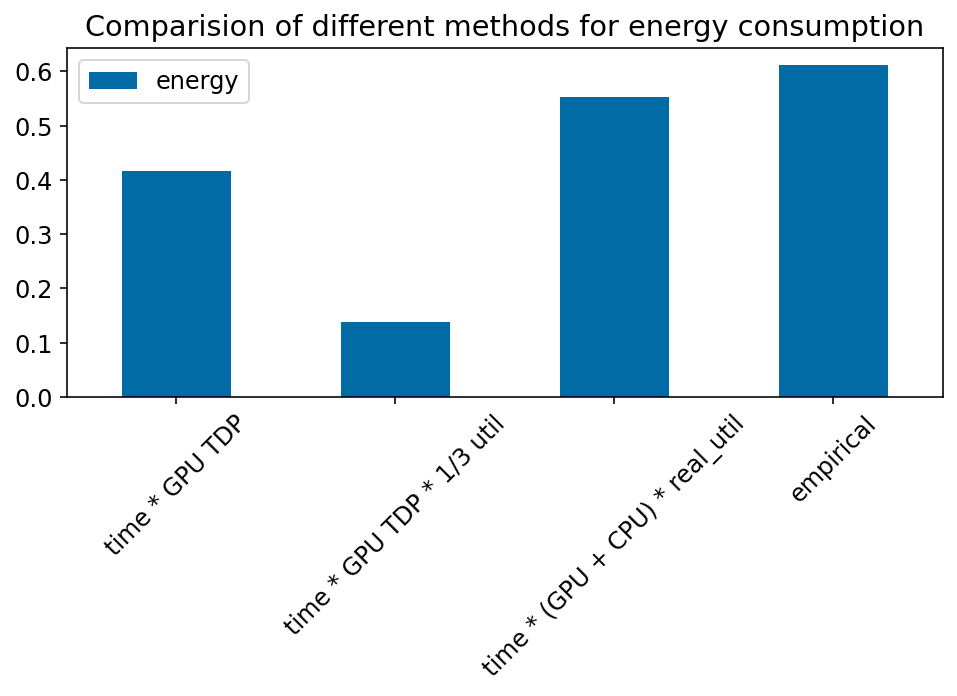

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
df.plot.bar(x='method', y='energy', rot=45,title="Comparision of different methods for energy consumption",ax=ax)
ax.set_xlabel("")
plt.tight_layout()
ax.figure.savefig("viz/compareEnergy.png",dpi=300)

## Test correlation

In [216]:
power_monitor_df = pd.read_csv("results/pretrain_power_monitor.csv")

In [217]:
power_monitor_df['last_changed'] = pd.to_datetime(power_monitor_df['last_changed'], errors='coerce')
power_monitor_df.dropna(subset=['last_changed'], inplace=True)
power_monitor_df.set_index('last_changed', inplace=True)

In [218]:
start_date = '2020-06-16'
end_date = '2020-06-16'
start_time = '21:38:59' #one hour behind
end_time = '23:18:51'
subset_df = power_monitor_df.loc[start_date:end_date].between_time(start_time, end_time)[['power_consumption']]
total_energy_pm = ((subset_df['power_consumption']).sum() * 3) / (1000 * 3600) #sampled every 3 sec
total_energy_pm

0.6127022608333333

In [219]:
end = '2020-06-17 00:18:51.137000'
start = '2020-06-16 22:38:59.567000'

start = datetime.strptime(start, "%Y-%m-%d %H:%M:%S.%f") - timedelta(hours=1, minutes=0)
end = datetime.strptime(end, "%Y-%m-%d %H:%M:%S.%f") - timedelta(hours=1, minutes=0)   

start_time = [start for i in range(0,95,5)] 
end_time = [start + timedelta(hours=0, minutes=i)
                 for i in range(5,100,5)] 

In [220]:
def energy_consumption(s_date,e_date,s_time,e_time):
    subset_df = power_monitor_df.loc[s_date:e_date].between_time(s_time, e_time)[['power_consumption']]
    return ((subset_df['power_consumption']).sum() * 3) / (1000 * 3600)

In [221]:
df_time_interval= pd.DataFrame(start_time,columns=['start'])

In [222]:
df_time_interval['end'] = end_time
df_time_interval['s_date'] = [x.date().strftime("%Y-%m-%d") for x in df_time_interval["start"]]
df_time_interval['e_date'] = [x.date().strftime("%Y-%m-%d") for x in df_time_interval["end"]]
df_time_interval['s_time'] = [x.time().strftime("%H:%M:%S") for x in df_time_interval["start"]]
df_time_interval['e_time'] = [x.time().strftime("%H:%M:%S") for x in df_time_interval["end"]]

In [223]:
for index, row in df_time_interval.iterrows(): 
    df_time_interval.at[index,'empirical'] = energy_consumption(row['s_date'],row['e_date'],
                                            row['s_time'],row['e_time'])

In [224]:
def model_based(time):
    return (time * ( GPU_TDP * GPU_utilisation/100 +  CPU_TDP * CPU_utilisation) / (1000 * 3600) )

In [225]:
for index, row in df_time_interval.iterrows(): 
    time = row['end'] - row['start']
    seconds = time.total_seconds()
    df_time_interval.at[index,'model_based'] = model_based(seconds)

In [226]:
df_time_interval.tail()

,start,end,s_date,e_date,s_time,e_time,empirical,model_based
14,2020-06-16 21:38:59.567,2020-06-16 22:53:59.567,2020-06-16,2020-06-16,21:38:59,22:53:59,0.458472,0.413807
15,2020-06-16 21:38:59.567,2020-06-16 22:58:59.567,2020-06-16,2020-06-16,21:38:59,22:58:59,0.489477,0.441394
16,2020-06-16 21:38:59.567,2020-06-16 23:03:59.567,2020-06-16,2020-06-16,21:38:59,23:03:59,0.520420,0.468981
17,2020-06-16 21:38:59.567,2020-06-16 23:08:59.567,2020-06-16,2020-06-16,21:38:59,23:08:59,0.551312,0.496569
18,2020-06-16 21:38:59.567,2020-06-16 23:13:59.567,2020-06-16,2020-06-16,21:38:59,23:13:59,0.582304,0.524156


coeff: 0.9999915643601635
r2: 0.9999831287914869


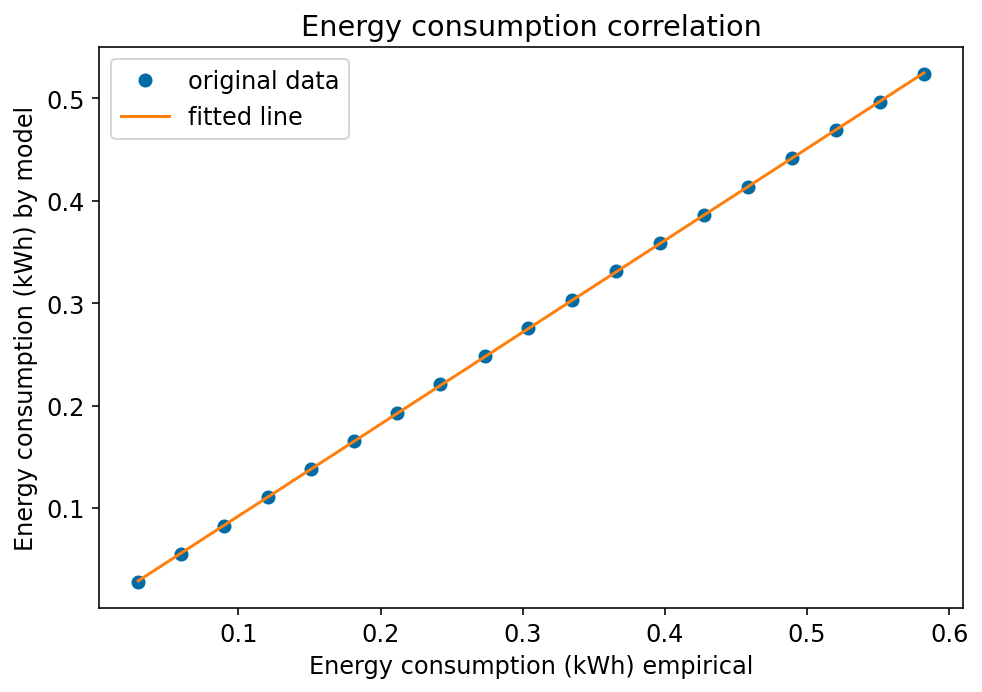

In [227]:
x = df_time_interval['empirical']
y = df_time_interval['model_based']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.xlabel("Energy consumption (kWh) empirical")
plt.ylabel("Energy consumption (kWh) by model")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/pretrain_model_vs_empirical.png',dpi=300)

In [228]:
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \n mae: {mae}")

rmse: 0.03365907492767219 
 mae: 0.0288736774871875


## See how the values scale with time using finetuning training 

In [84]:
df_finetune = pd.read_csv("results/model_pm_energy_finetune.csv")

In [86]:
df_finetune['power'].count()

51

In [87]:
df_finetune['time * GPU TDP'] = df_finetune['time_in_hour'] * GPU_TDP / 1000
df_finetune['time * GPU TDP * 1/3 util'] = (df_finetune['time_in_hour'] * GPU_TDP * 1/3) / 1000
df_finetune['time * (GPU + CPU) * real_util'] = ((df_finetune['time_in_hour'] *  GPU_TDP * GPU_utilisation/100 )
  +  (df_finetune['cpu_time']/3600 * CPU_TDP * CPU_utilisation)) / 1000

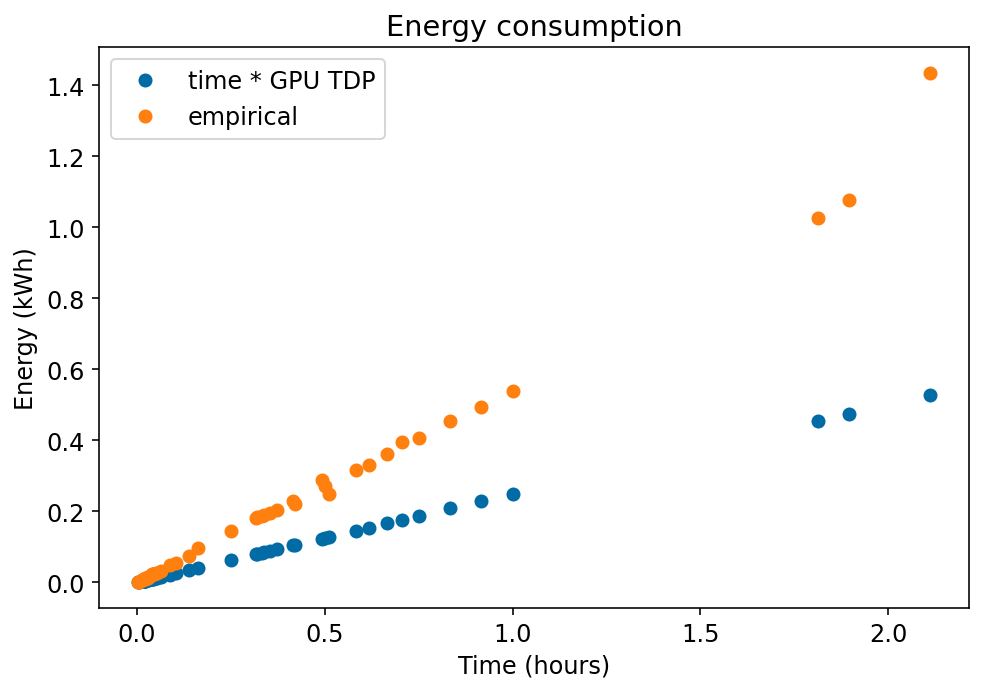

In [105]:
x = df_finetune['time_in_hour']
y1 = df_finetune['time * (GPU + CPU) * real_util']
y2 = df_finetune['pm_energy_consumption']
plt.figure(figsize=(7,5))
plt.plot(x, y1,'o', label="time * GPU TDP")
plt.plot(x, y2,'o', label="empirical")
plt.xlabel("Time (hours)")
plt.ylabel("Energy (kWh)")
plt.title("Energy consumption")
plt.legend()
plt.tight_layout()
plt.savefig('viz/mlco2ModelVsPMPower.png',dpi=300)

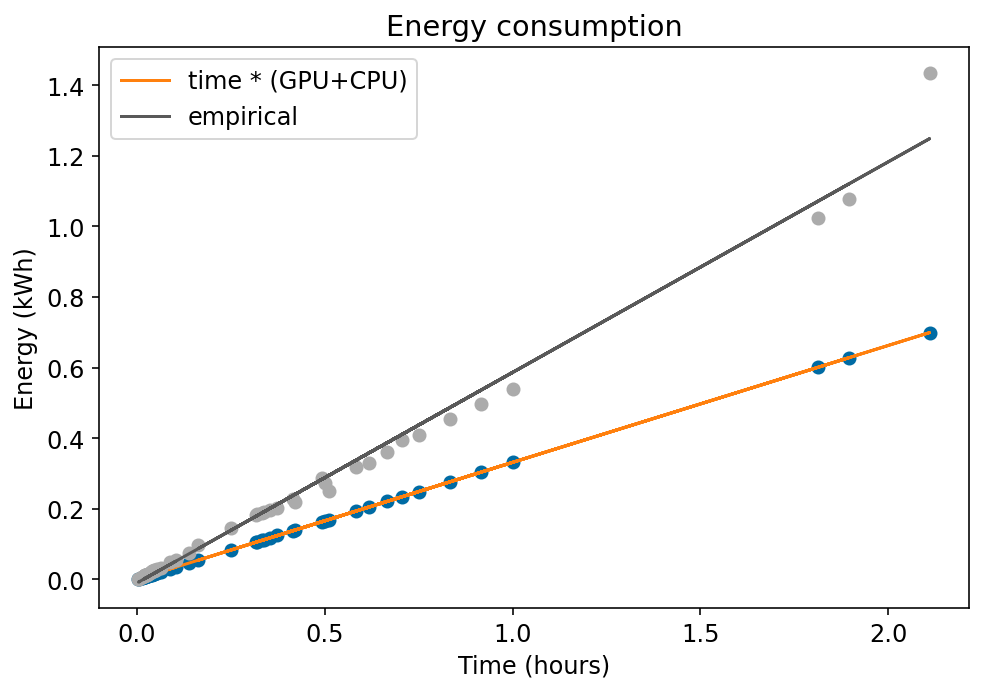

In [94]:

x = df_finetune['time_in_hour']
y1 = df_finetune['time * (GPU + CPU) * real_util']
y2 = df_finetune['pm_energy_consumption']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y1)
plt.plot(x, y1,'o')
plt.plot(x, slope * x + intercept, label='time * (GPU+CPU)')
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y2)
plt.plot(x, y2,'o')
plt.plot(x, slope * x + intercept, label='empirical')
plt.xlabel("Time (hours)")
plt.ylabel("Energy (kWh)")
plt.title("Energy consumption")
plt.legend()
plt.tight_layout()
plt.savefig('viz/CPU_GPU_ModelVsPMPower.png',dpi=300)

In [90]:
stat, p = stats.normaltest(x)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=35.934, p=0.000
Sample does not look Gaussian (reject H0)


In [ ]:
x.hist()

In [92]:
df_64 = df_finetune.loc[(df_finetune.batchsize == 64) & (df_finetune.max_seq_len == 128)]
df_64 = df_64.sort_values('dataset_size')

coeff: 0.9939498548250272
r2: 0.9879363139066926


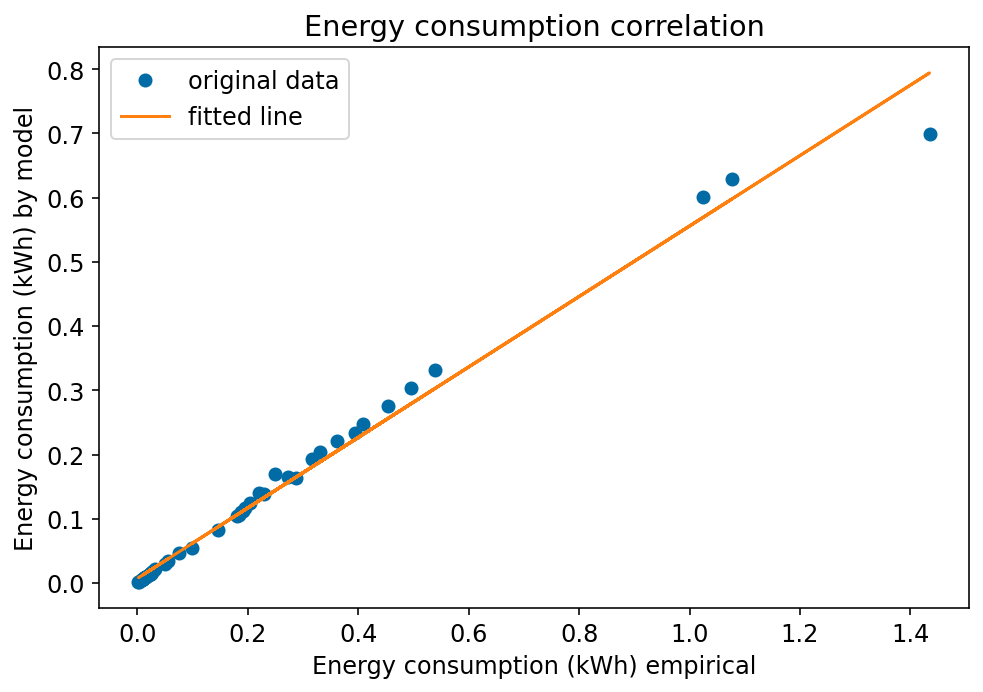

In [214]:
x = df_finetune['pm_energy_consumption']
y = df_finetune['time * (GPU + CPU) * real_util']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.ylabel("Energy consumption (kWh) by model")
plt.xlabel("Energy consumption (kWh) empirical")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/Corr_CPU_GPU_ModelVsPMPower.png',dpi=300)

In [215]:
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \n mae: {mae}")

rmse: 0.15525863897786293 
 mae: 0.08172864013759067


## merge data 

In [242]:
df_finetune.rename(columns={'pm_energy_consumption':'empirical','time * (GPU + CPU) * real_util':'model_based'},
                   inplace=True)

In [243]:
merge_df = df_finetune.append(df_time_interval)

coeff: 0.9508365660384722
r2: 0.9040901753158339


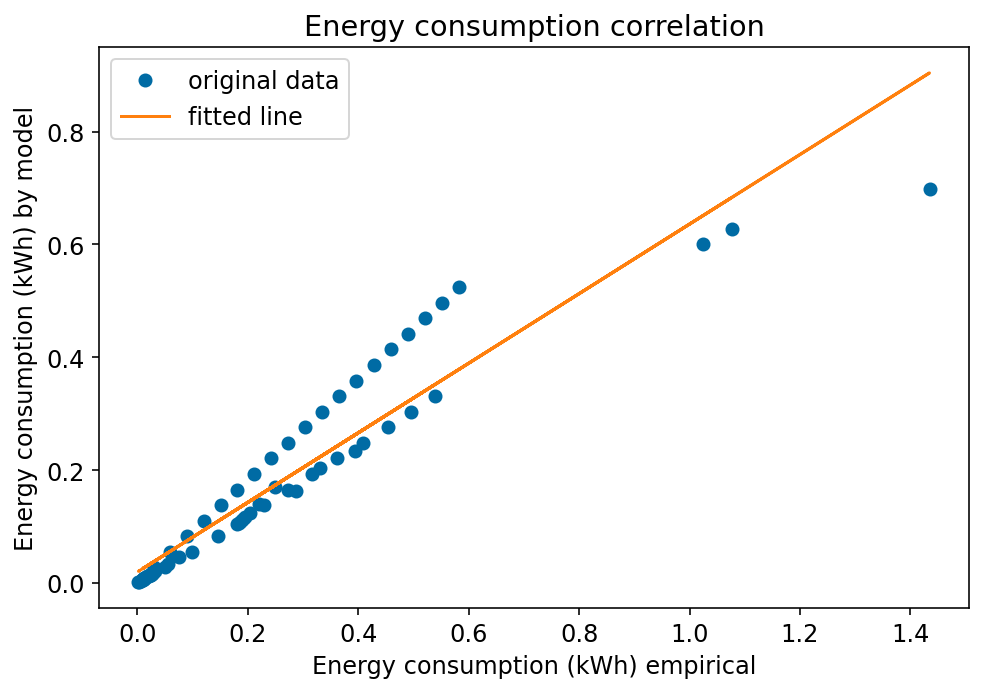

In [244]:
x = merge_df['empirical']
y = merge_df['model_based']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.xlabel("Energy consumption (kWh) empirical")
plt.ylabel("Energy consumption (kWh) by model")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/model_vs_empirical.png',dpi=300)